# Produce geometrical XY map

<i>
This notebook takes a clean kDST and a correction file,
performs the lifetime correction and measures the energy
at different points of the XY plane. The resulting map
is stored in the same correction file.
</i>

### Notebook configuration

In [1]:
run_number          = 4841
input_dst_filename  = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"
overwrite           = True

Zrange  =   50,  550
XYrange = -200,  200
Znbins  =   10
XYnbins = [ 40,  60,  80,
           100, 120, 140,
           160, 180, 200]
nX, nY  =    3,   3

# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [2]:
import os
import time
import collections
import warnings

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import gauss_seed
from icaro.core.fit_functions import relative_errors
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(with_titles)
save   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

%matplotlib inline

### Initialization

In [3]:
Zbins     =     np.linspace(* Zrange,  Znbins+1)
XYbins    = {n: np.linspace(*XYrange,   n    +1) for n in XYnbins}
XYcenters = {n: shift_to_bin_centers(bins) for n, bins in XYbins.items()}
XYpitch   = {n: np.diff(bins)[0]           for n, bins in XYbins.items()}

input_dst_filename   = os.path.expandvars( input_dst_filename)
correction_filename  = os.path.expandvars(correction_filename)
correction_filenames = {n: correction_filename.replace(".h5", f"_GEO{p:.1f}mm.h5") for n, p in XYpitch.items()}

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

### Read data

In [4]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 782547 
Total number of events: 779357


In [5]:
ZcorrectionE = dstf.load_lifetime_xy_corrections(correction_filename,
                                                 group = "XYcorrections",
                                                 node  = "Lifetime")

ZcorrectionQ = dstf.load_lifetime_xy_corrections(correction_filename,
                                                 group = "XYcorrections",
                                                 node  = "QLifetime")

In [6]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values * ZcorrectionE(Z, X, Y).value
Q = dst.S2q.values * ZcorrectionQ(Z, X, Y).value

### Event distribution

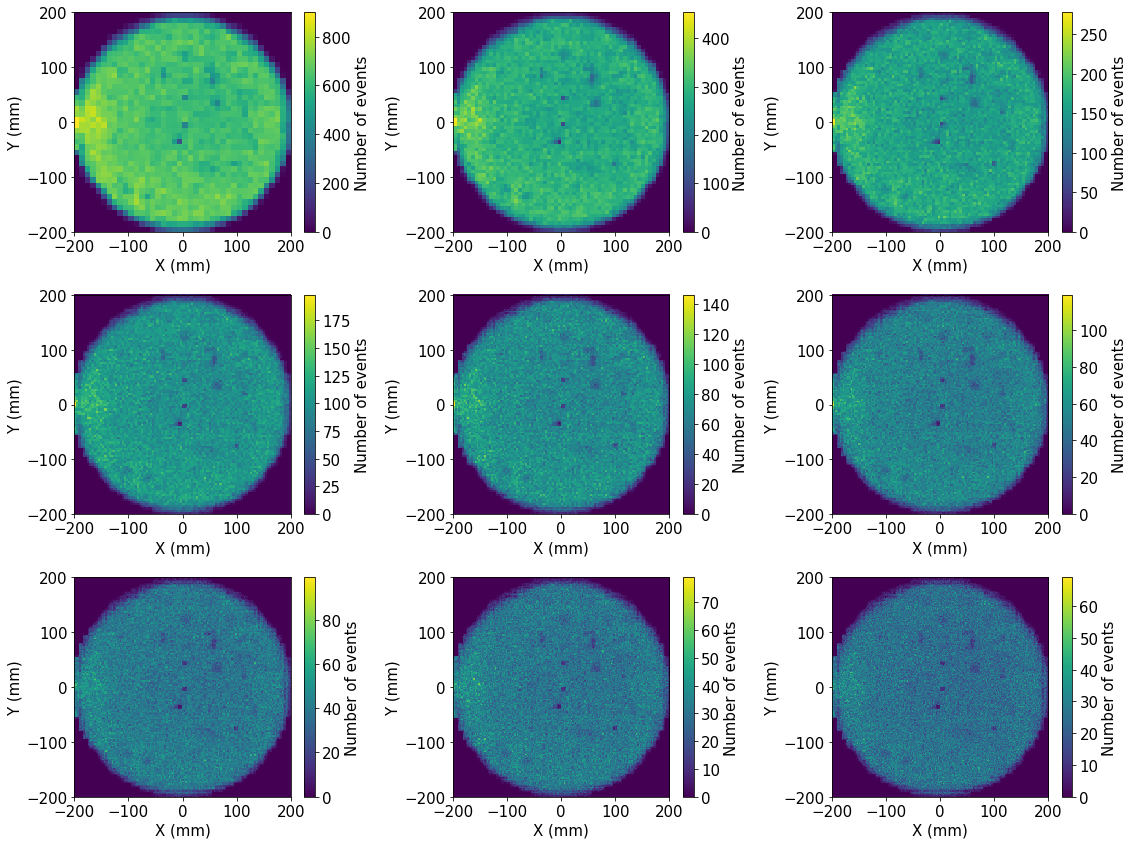

In [7]:
Nevt = {}
i    = 1
for n in XYnbins:
    xybins  = XYbins [n]
    xypitch = XYpitch[n]

    plt.subplot(nY, nX, i)
    nevt, *_ = plt.hist2d(X, Y, (xybins, xybins))
    plt.colorbar().set_label("Number of events")
    labels("X (mm)", "Y (mm)", f"Event distribution for {xypitch:.1f} mm pitch")

    Nevt[n]  = nevt
    i       += 1

plt.tight_layout()
save("Event_distribution_different_pitches_XY")

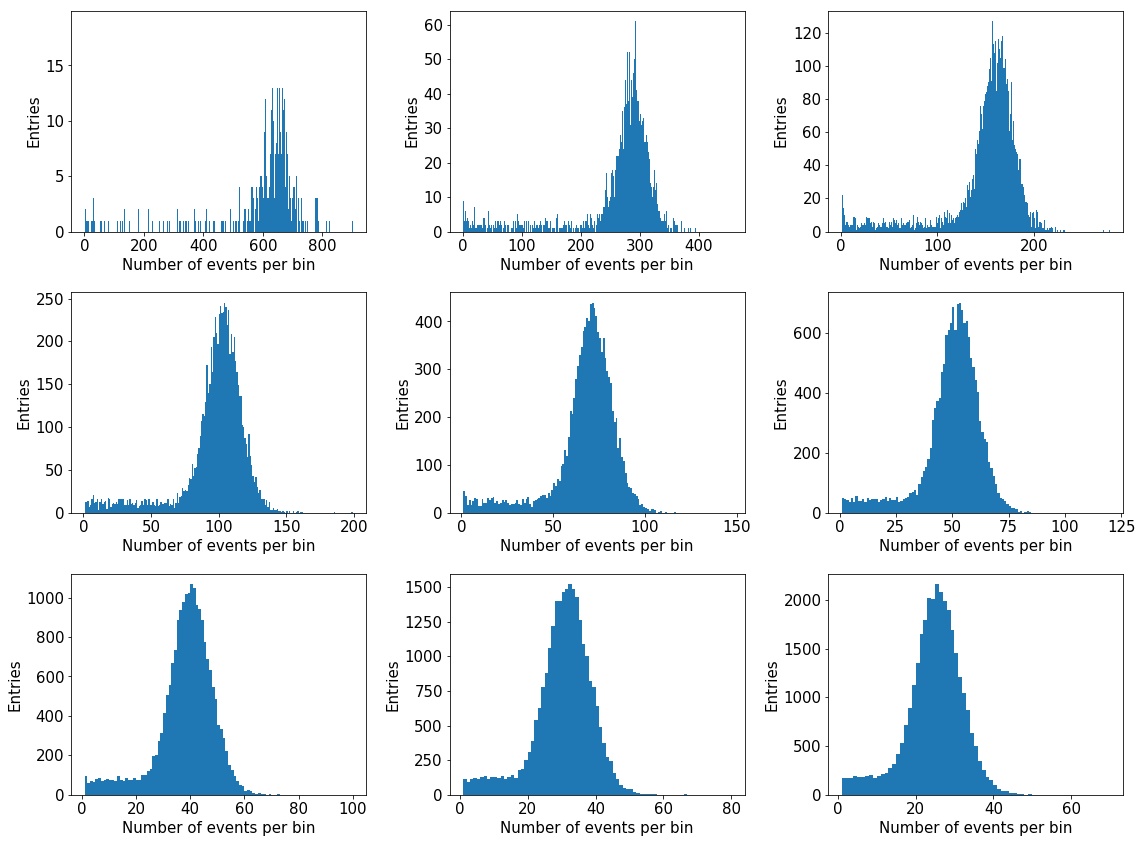

In [8]:
for i, n in enumerate(XYnbins, start=1):
    nevt     = Nevt[n]
    xypitch  = XYpitch[n]
    nevt_max = int(np.max(nevt))

    plt.subplot(nY, nX, i)
    plt.hist(nevt.flatten(), nevt_max, (1, nevt_max+1))
    labels("Number of events per bin", "Entries", f"# events per bin for {xypitch:.1f} mm pitch")
    i += 1

plt.tight_layout()
save("Event_distribution_different_pitches")

### Compute geometry map

In [9]:
Eave  = {}
Eaveu = {}

E_mean  = {}
Eu_mean = {}
E_std   = {}
Eu_std  = {}

E_min  = {}
E_max  = {}
Eu_min = {}
Eu_max = {}

Qave  = {}
Qaveu = {}

Q_mean  = {}
Qu_mean = {}
Q_std   = {}
Qu_std  = {}

Q_min  = {}
Q_max  = {}
Qu_min = {}
Qu_max = {}

for n in XYnbins:
    *_, Eave_, Eaveu_ = fitf.profileXY(X, Y, E, n, n, XYrange, XYrange)
    *_, Qave_, Qaveu_ = fitf.profileXY(X, Y, Q, n, n, XYrange, XYrange)

    Eaveu_            = relative_errors(Eave_, Eaveu_, percentual=True)
    Qaveu_            = relative_errors(Qave_, Qaveu_, percentual=True)

    Eok               = Eave_ > 1e3
    Qok               = Qave_ > 1e1

    Eave   [n] = Eave_
    Eaveu  [n] = Eaveu_
    
    E_mean [n] = np.mean(Eave_ [Eok])
    E_std  [n] = np.std (Eave_ [Eok])
    Eu_mean[n] = np.mean(Eaveu_[Eok])
    Eu_std [n] = np.std (Eaveu_[Eok])
    
    E_min  [n] =      E_mean[n] - 3.0 *  E_std[n]
    E_max  [n] =      E_mean[n] + 2.0 *  E_std[n]

    Eu_min [n] = max(Eu_mean[n] - 1.5 * Eu_std[n], 1e-3)
    Eu_max [n] =     Eu_mean[n] + 2.0 * Eu_std[n]

    
    Qave   [n] = Qave_
    Qaveu  [n] = Qaveu_
    
    Q_mean [n] = np.mean(Qave_ [Qok])
    Q_std  [n] = np.std (Qave_ [Qok])
    Qu_mean[n] = np.mean(Qaveu_[Qok])
    Qu_std [n] = np.std (Qaveu_[Qok])
    
    Q_min  [n] =      Q_mean[n] - 3.0 *  Q_std[n]
    Q_max  [n] =      Q_mean[n] + 2.0 *  Q_std[n]

    Qu_min [n] = max(Qu_mean[n] - 1.5 * Qu_std[n], 1e-3)
    Qu_max [n] =     Qu_mean[n] + 2.0 * Qu_std[n]

### Fit example

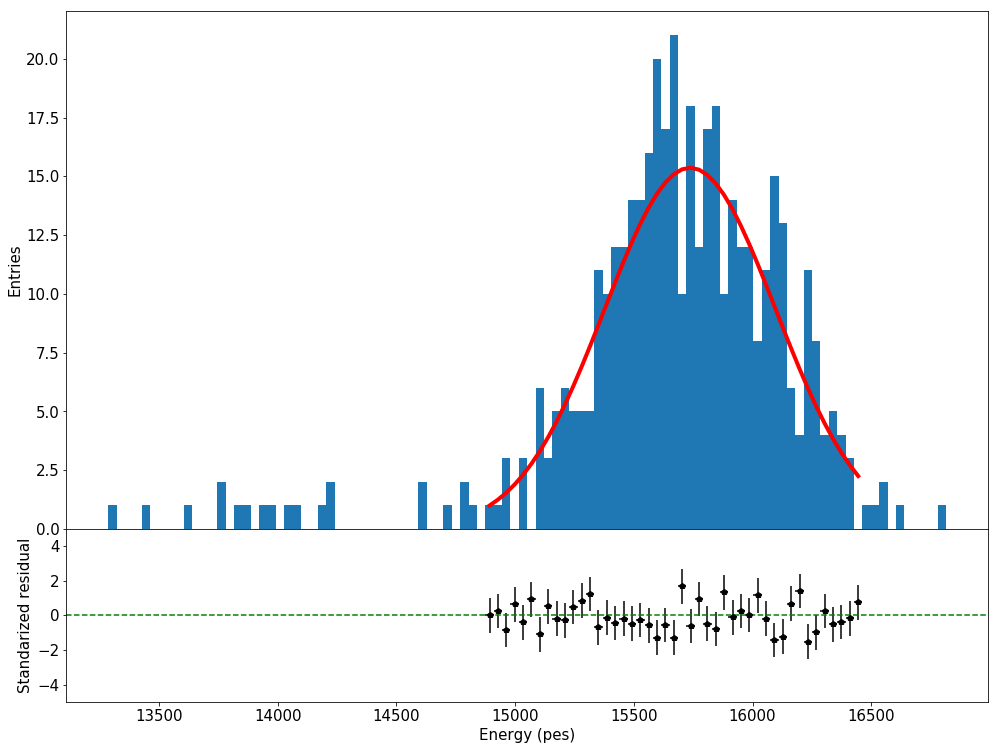

In [10]:
xlim =  15,  20
ylim = -25, -10
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
e    = E[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
y, x, _   = hist(e, 100, new_figure=False)
seed      = gauss_seed(x, y)
fit_range = seed[1] - seed[2], seed[1] + seed[2]
x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
f         = fitf.fit(fitf.gauss, x, y, seed, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Entries", "Energy fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, np.diff(x)[0]/2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5,+5)
labels("Energy (pes)", "Standarized residual")

save("Energy_fit_example")

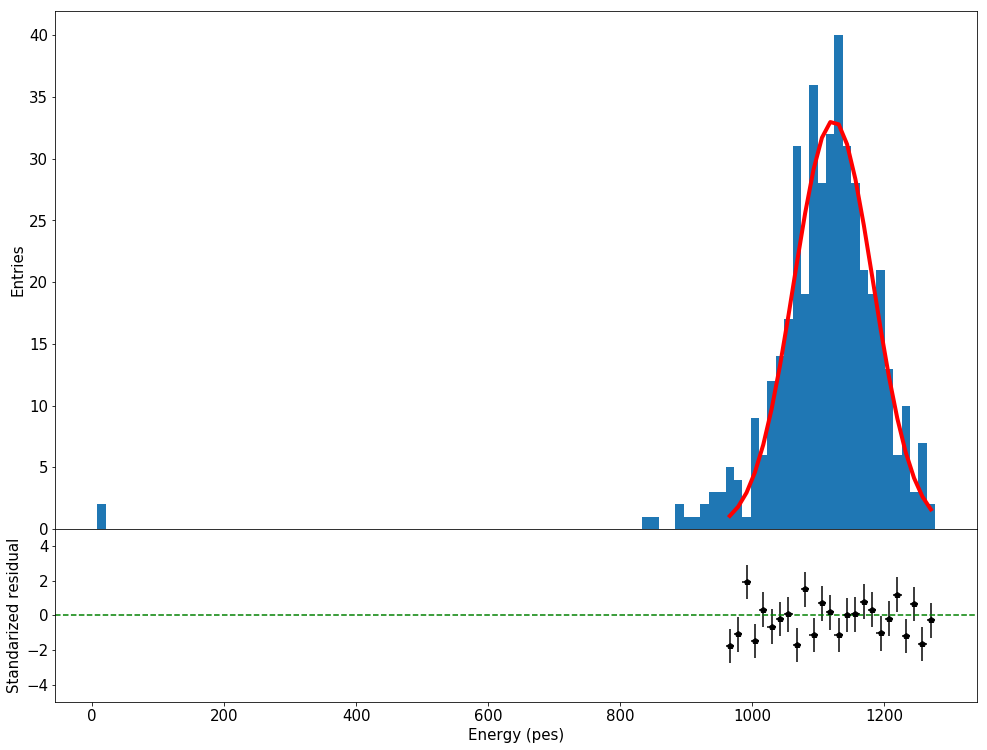

In [11]:
xlim =  15,  20
ylim = -25, -10
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
q    = Q[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
y, x, _   = hist(q, 100, new_figure=False)
seed      = gauss_seed(x, y)
fit_range = seed[1] - 3 * seed[2], seed[1] + 3 * seed[2]
x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
f         = fitf.fit(fitf.gauss, x, y, seed, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Entries", "Energy fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, np.diff(x)[0]/2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5,+5)
labels("Energy (pes)", "Standarized residual")

save("Charge_fit_example")

### Energy map display

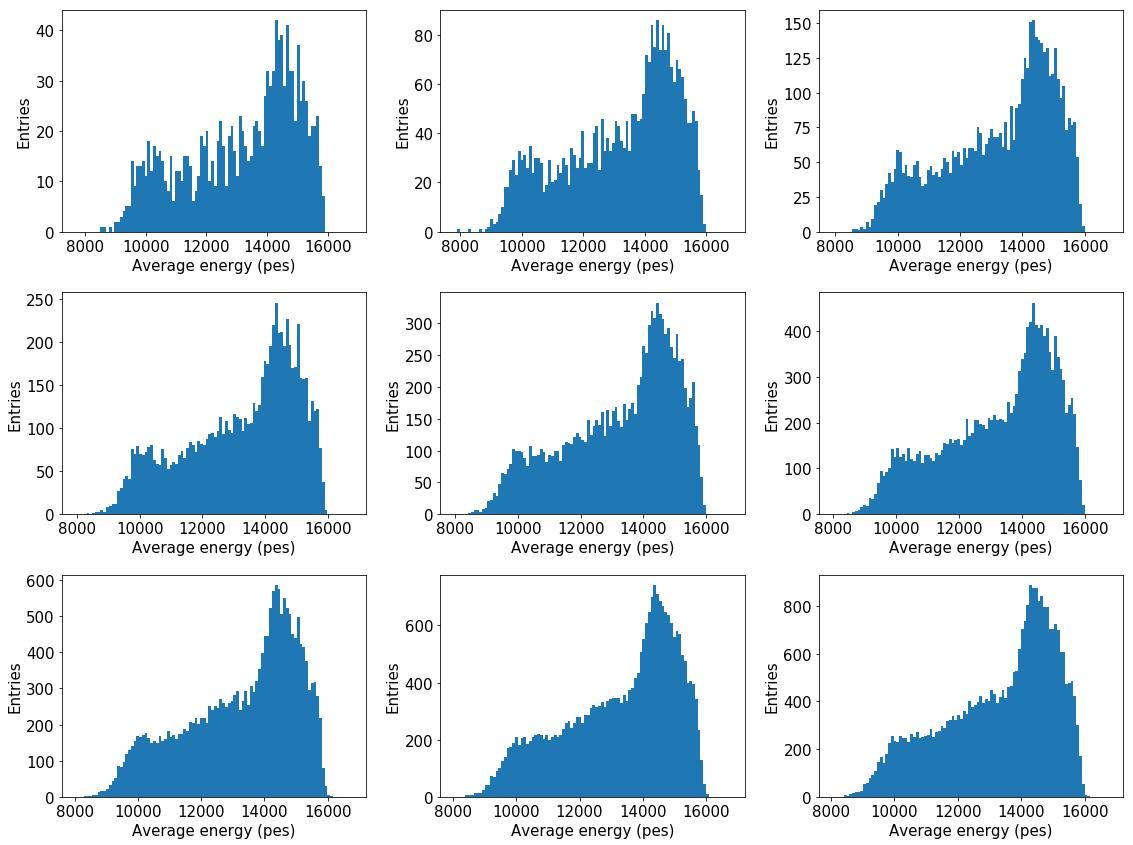

In [12]:
for i, n in enumerate(XYnbins, start=1):
    pitch = XYpitch[n]
    plt.subplot(nY, nX, i)
    plt.hist(Eave[n].flatten(), 100, (E_min[n], E_max[n]))
    labels("Average energy (pes)", "Entries", f"Average energy for {pitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_distributions")

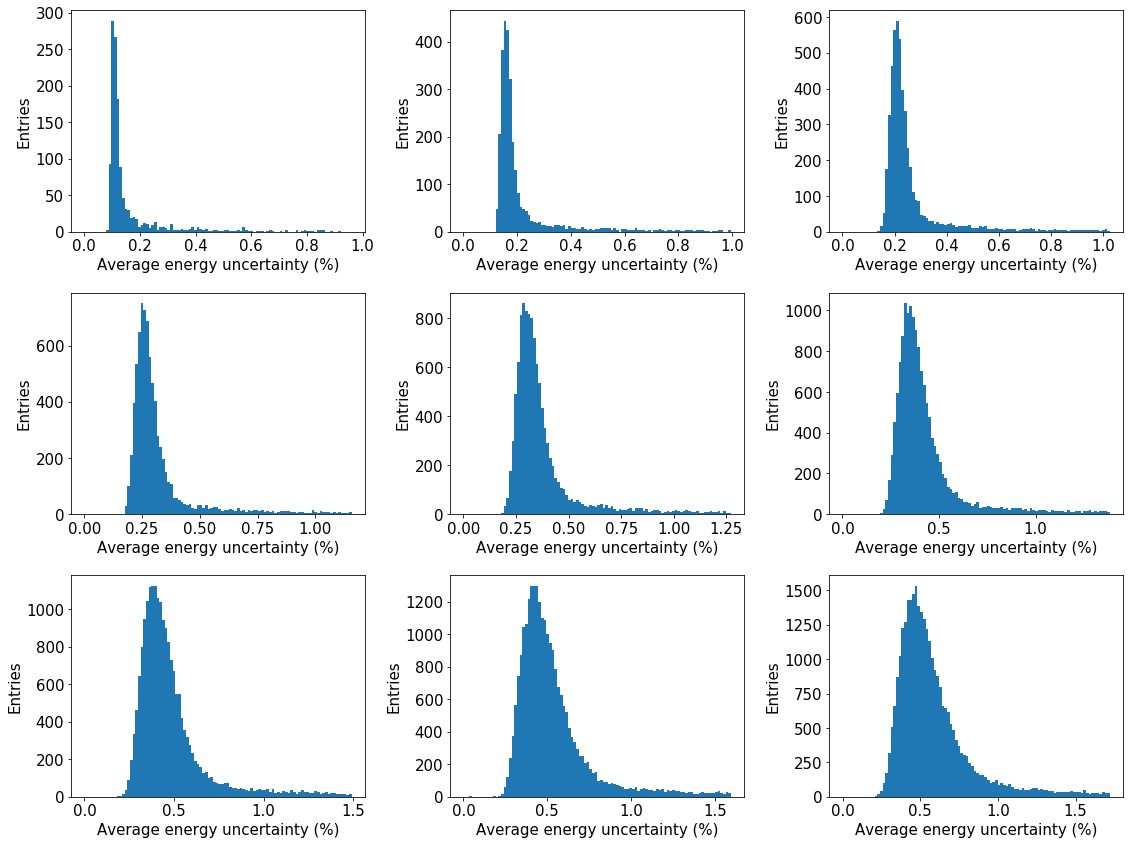

In [13]:
for i, n in enumerate(XYnbins, start=1):
    pitch = XYpitch[n]
    plt.subplot(nY, nX, i)
    plt.hist(Eaveu[n].flatten(), 100, (Eu_min[n], Eu_max[n]))
    labels("Average energy uncertainty (%)", "Entries", f"Average energy unc. for {pitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_uncertainty_distributions")

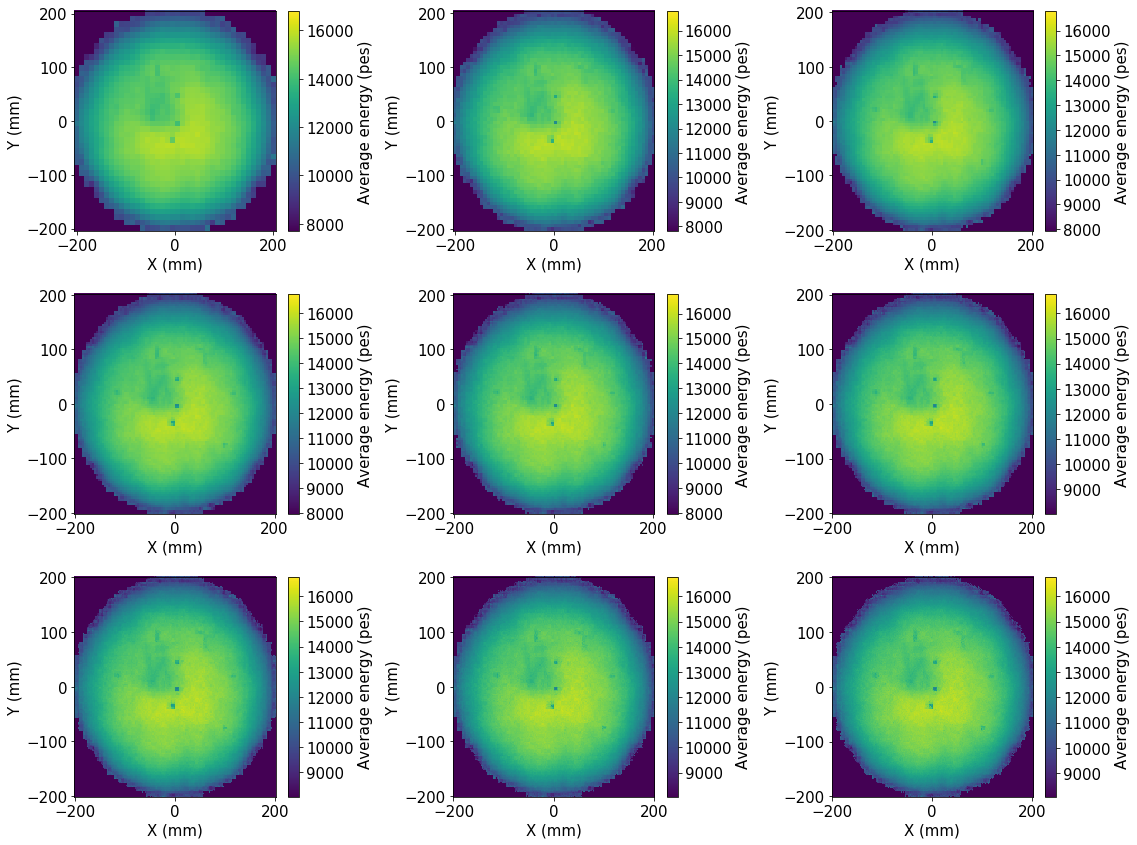

In [14]:
for i, n in enumerate(XYnbins, start=1):
    pitch = XYpitch[n]
    plt.subplot(nY, nX, i)
    *_, cb = display_matrix(XYcenters[n], XYcenters[n], Eave[n],
                            vmin = E_min[n],
                            vmax = E_max[n],
                            cmap = default_cmap,
                            new_figure = False)
    cb.set_label("Average energy (pes)")
    labels("X (mm)", "Y (mm)", f"Average energy for {pitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_maps")

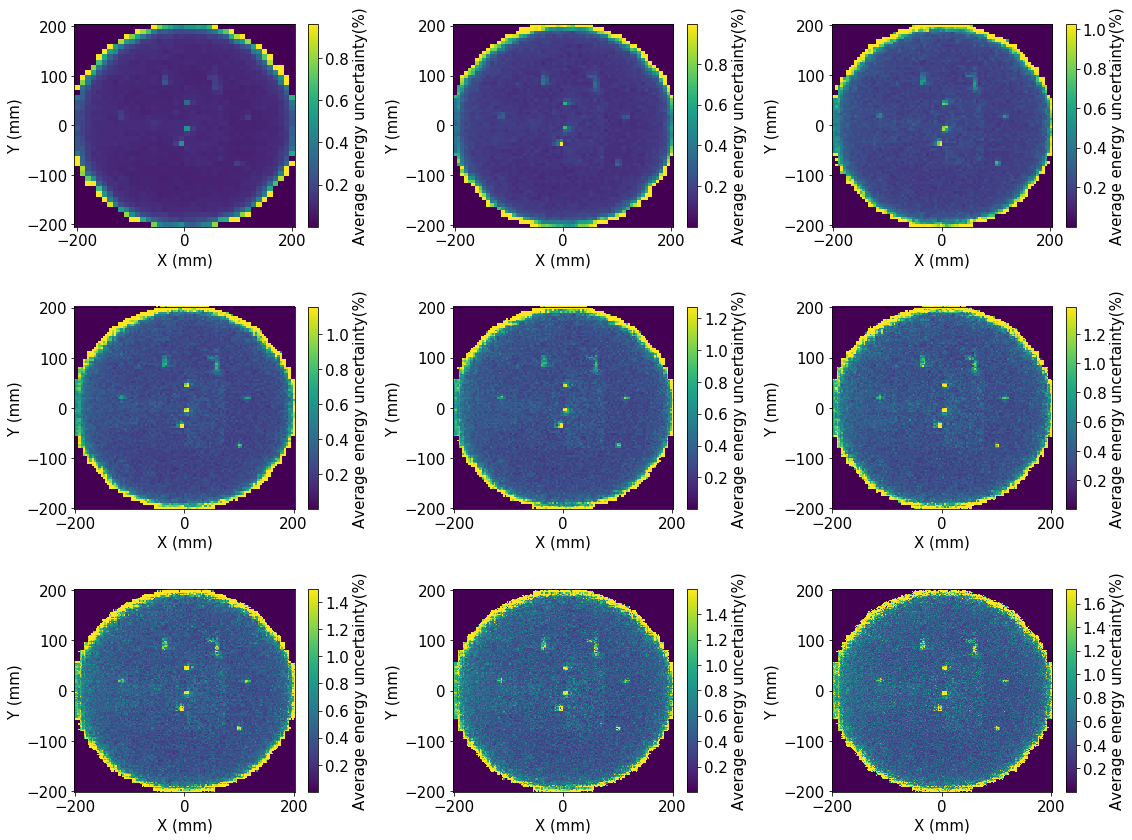

In [15]:
for i, n in enumerate(XYnbins, start=1):
    pitch = XYpitch[n]
    plt.subplot(nY, nX, i)
    *_, cb = display_matrix(XYcenters[n], XYcenters[n], Eaveu[n],
                            vmin = Eu_min[n],
                            vmax = Eu_max[n],
                            cmap = default_cmap,
                            new_figure = False)
    cb.set_label("Average energy uncertainty(%)")
    labels("X (mm)", "Y (mm)", f"Average energy unc. for {pitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_uncertainty_maps")

### Charge map display

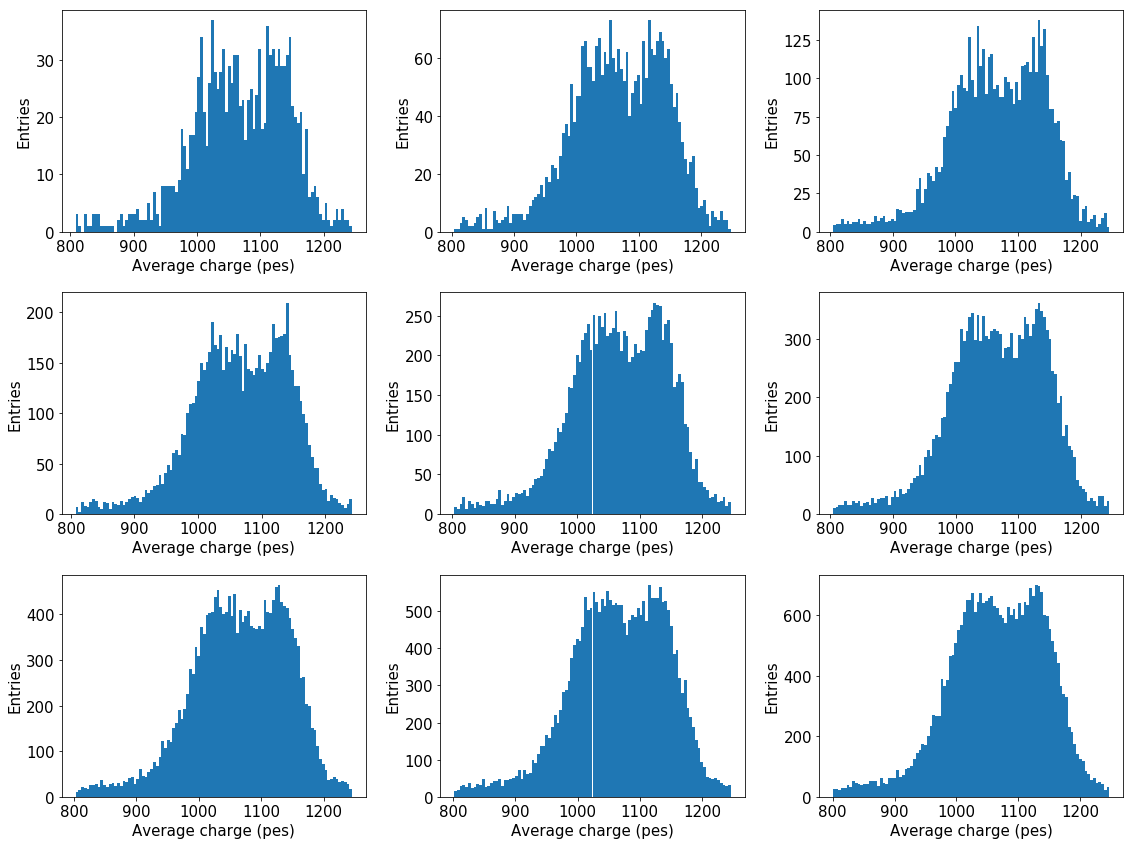

In [16]:
for i, n in enumerate(XYnbins, start=1):
    pitch = XYpitch[n]
    plt.subplot(nY, nX, i)
    plt.hist(Qave[n].flatten(), 100, (Q_min[n], Q_max[n]))
    labels("Average charge (pes)", "Entries", f"Average charge for {pitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_distributions")

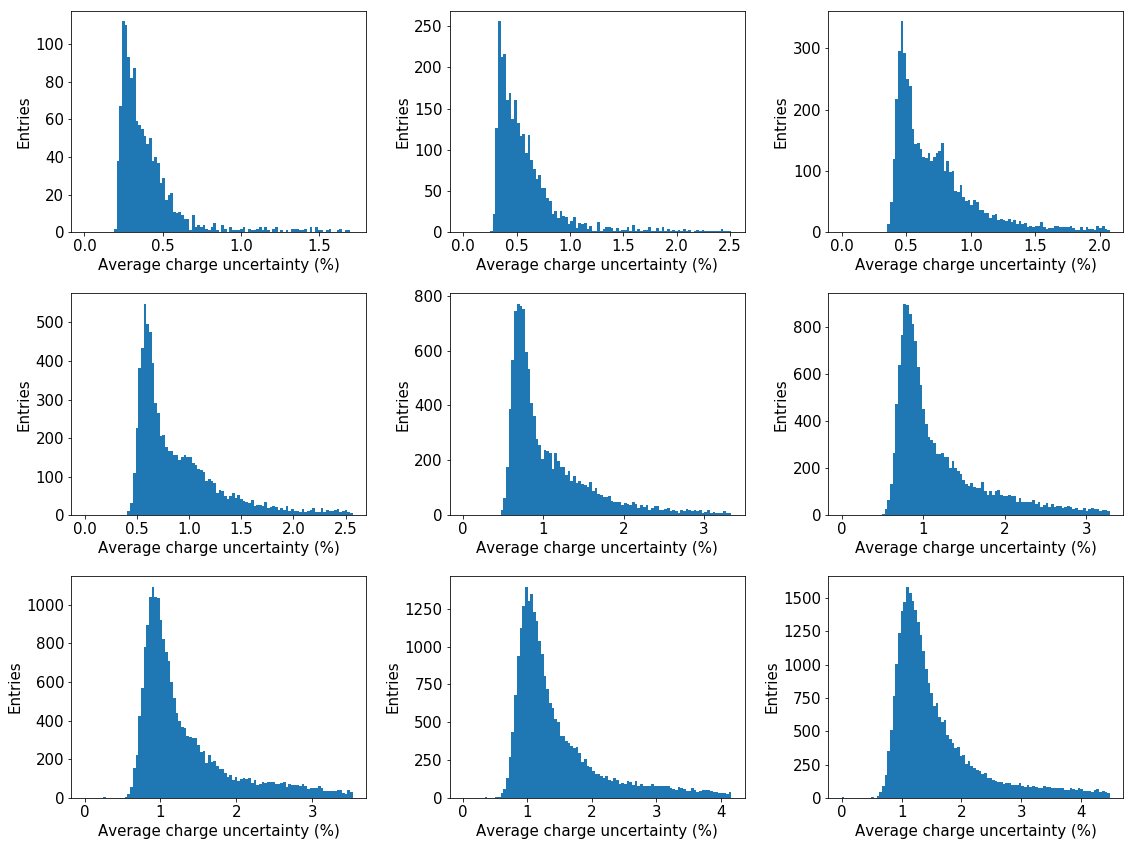

In [17]:
for i, n in enumerate(XYnbins, start=1):
    pitch = XYpitch[n]
    plt.subplot(nY, nX, i)
    plt.hist(Qaveu[n].flatten(), 100, (Qu_min[n], Qu_max[n]))
    labels("Average charge uncertainty (%)", "Entries", f"Average charge unc. for {pitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_uncertainty_distributions")

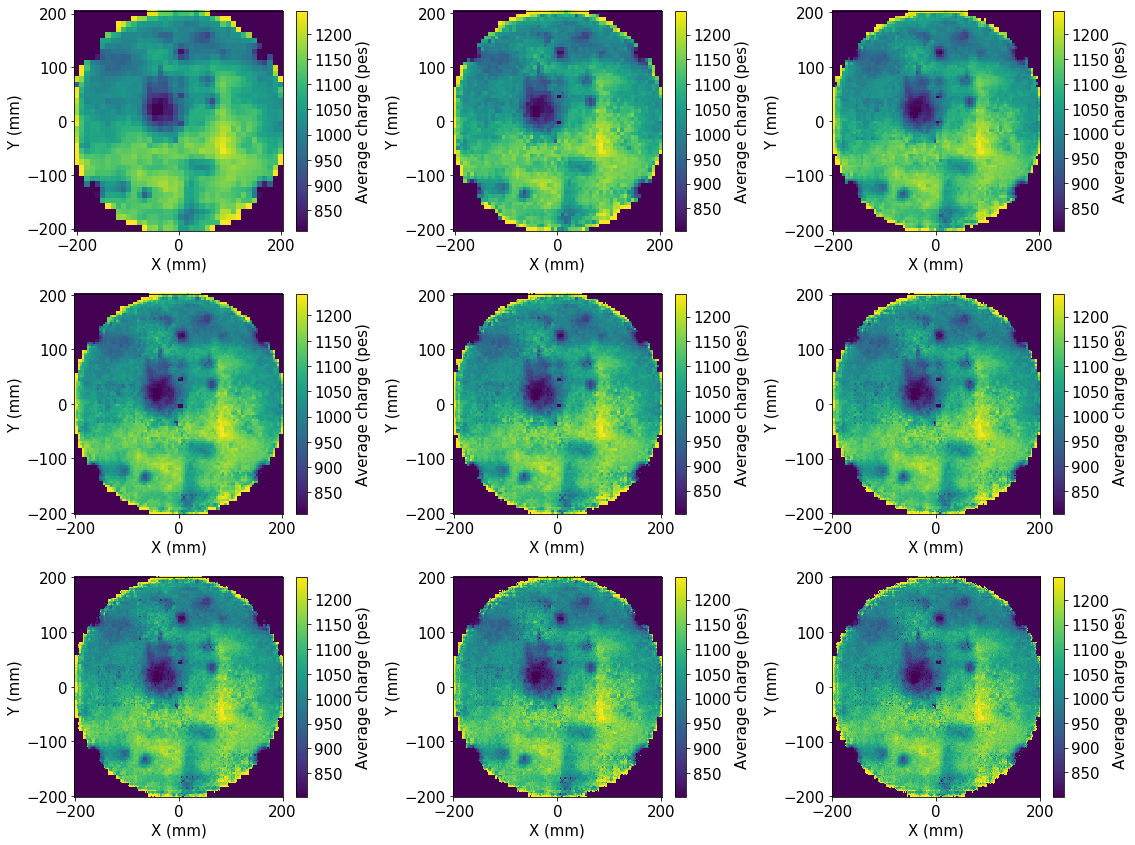

In [18]:
for i, n in enumerate(XYnbins, start=1):
    pitch = XYpitch[n]
    plt.subplot(nY, nX, i)
    *_, cb = display_matrix(XYcenters[n], XYcenters[n], Qave[n],
                            vmin = Q_min[n],
                            vmax = Q_max[n],
                            cmap = default_cmap,
                            new_figure = False)
    cb.set_label("Average charge (pes)")
    labels("X (mm)", "Y (mm)", f"Average charge for {pitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_maps")

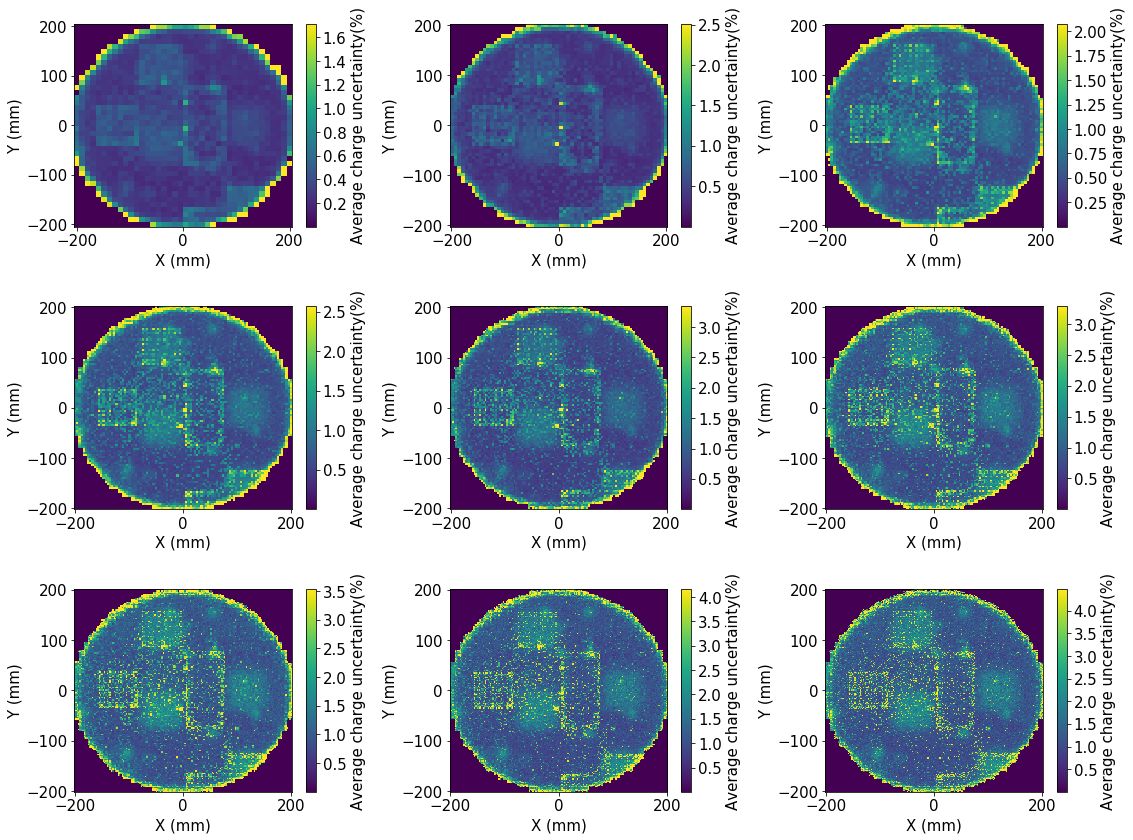

In [21]:
for i, n in enumerate(XYnbins, start=1):
    pitch = XYpitch[n]
    plt.subplot(nY, nX, i)
    *_, cb = display_matrix(XYcenters[n], XYcenters[n], Qaveu[n],
                            vmin = Qu_min[n],
                            vmax = Qu_max[n],
                            cmap = default_cmap,
                            new_figure = False)
    cb.set_label("Average charge uncertainty(%)")
    labels("X (mm)", "Y (mm)", f"Average charge unc. for {pitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_uncertainty_maps")

### Produce HDF5 output

In [20]:
with tb.open_file(correction_filename, "r+") as output_file:
    for n in XYnbins:
        pitch      = XYpitch[n]
        group      =  "XYcorrections"
        table_name = f"GeometryE_{pitch:.1f}mm"
        if (overwrite                                      and
            group      in output_file.root                 and
            table_name in getattr(output_file.root, group)):
            output_file.remove_node(getattr(output_file.root, group), table_name)
        write = kdstio.xy_correction_writer(output_file,
                                            group      = group,
                                            table_name = table_name)
        write(XYcenters[n], XYcenters[n], Eave[n], Eaveu[n] * Eave[n] / 100, Nevt[n])

        table = getattr(getattr(output_file.root, group), table_name)
        table.attrs.xy_bins  = n
        table.attrs.xy_pitch = pitch

        table_name = f"GeometryQ_{pitch:.1f}mm"
        if (overwrite                                      and
            group      in output_file.root                 and
            table_name in getattr(output_file.root, group)):
            output_file.remove_node(getattr(output_file.root, group), table_name)
        write = kdstio.xy_correction_writer(output_file,
                                            group      = group,
                                            table_name = table_name)
        write(XYcenters[n], XYcenters[n], Qave[n], Qaveu[n] * Qave[n] / 100, Nevt[n])

        table = getattr(getattr(output_file.root, group), table_name)
        table.attrs.xy_bins  = n
        table.attrs.xy_pitch = pitch